In [1]:
import os
import dask
from dask.distributed import Client
from azureml.core import Run

In [2]:
packages = 'matplotlib'

def update_packages(packages):
    os.system(f'pip install --upgrade {packages}')

In [3]:
run   = Run.get_context()
nodes = run.get_metrics()['nodes']

In [4]:
c = Client(f'{run.get_metrics()["scheduler"]}')
c

Client Scheduler: tcp://10.3.0.5:8786 Dashboard: http://10.3.0.5:8787/status,Cluster Workers: 25 Cores: 400 Memory: 2.96 TB


In [5]:
to_compute = dask.delayed([dask.delayed(update_packages)(packages) for i in range(nodes)])
to_compute.compute();

In [6]:
c.restart()

Client Scheduler: tcp://10.3.0.5:8786 Dashboard: http://10.3.0.5:8787/status,Cluster Workers: 25 Cores: 400 Memory: 2.96 TB


### Connect to cluster

In [7]:
import os
import glob
import dask
import time
import joblib
import fsspec
import socket
import matplotlib

import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt

from datetime import datetime
from dask.distributed import Client
from IPython.core.display import HTML
from dask_ml.xgboost import XGBRegressor

from azureml.core import Run, Model

%matplotlib inline

In [8]:
run = Run.get_context()
run

Experiment,Id,Type,Status,Details Page,Docs Page
dask-dask-demo,dask-dask-demo_1580440649_506153b5,azureml.scriptrun,Running,Link to Azure Machine Learning studio,Link to Documentation


In [9]:
c = Client(f'{run.get_metrics()["scheduler"]}')
c

Client Scheduler: tcp://10.3.0.5:8786 Dashboard: http://10.3.0.5:8787/status,Cluster Workers: 25 Cores: 400 Memory: 2.96 TB


In [10]:
STORAGE_OPTIONS = {
    'account_name': run.experiment.workspace.datastores['gen2'].account_name,
    'account_key' : run.experiment.workspace.datastores['gen2'].account_key
}

protocol  = 'abfs'
container = 'datasets'

In [11]:
files = glob.glob('../../../../gen2/noaa/isd/year=*/month=*/*.parquet')
files = [f'{protocol}://{container}/{file[17:]}' for file in files]
files[-5:]

['abfs://datasets/noaa/isd/year=2018/month=5/part-00066-tid-9138739344806125380-ef942066-1d58-49f9-8ecb-3329cbe6e57e-383761.c000.snappy.parquet',
 'abfs://datasets/noaa/isd/year=2018/month=6/part-00049-tid-9138739344806125380-ef942066-1d58-49f9-8ecb-3329cbe6e57e-383744.c000.snappy.parquet',
 'abfs://datasets/noaa/isd/year=2018/month=7/part-00107-tid-9138739344806125380-ef942066-1d58-49f9-8ecb-3329cbe6e57e-383859.c000.snappy.parquet',
 'abfs://datasets/noaa/isd/year=2018/month=8/part-00103-tid-9138739344806125380-ef942066-1d58-49f9-8ecb-3329cbe6e57e-383807.c000.snappy.parquet',
 'abfs://datasets/noaa/isd/year=2018/month=9/part-00089-tid-9138739344806125380-ef942066-1d58-49f9-8ecb-3329cbe6e57e-383784.c000.snappy.parquet']

In [12]:
df = dd.read_parquet(files, engine='pyarrow', storage_options=STORAGE_OPTIONS)#, dtype={'usaf': 'object'}, blocksize='5GB')
%time df.head()

CPU times: user 19 ms, sys: 0 ns, total: 19 ms
Wall time: 7.31 s


,usaf,wban,datetime,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,...,pastWeatherIndicator,precipTime,precipDepth,snowDepth,stationName,countryOrRegion,p_k,year,day,version
0,724755,93129,2008-01-01 00:53:00,37.702,-113.097,1712.0,350.0,3.6,-8.3,1036.2,...,NaN,1.0,0.0,NaN,CEDAR CITY REGIONAL ARPT,US,724755-93129,2008,1,1.0
1,724755,93129,2008-01-01 01:53:00,37.702,-113.097,1712.0,340.0,4.1,-11.1,1037.3,...,NaN,1.0,0.0,NaN,CEDAR CITY REGIONAL ARPT,US,724755-93129,2008,1,1.0
2,724755,93129,2008-01-01 02:53:00,37.702,-113.097,1712.0,NaN,2.1,-11.7,1039.7,...,NaN,1.0,0.0,NaN,CEDAR CITY REGIONAL ARPT,US,724755-93129,2008,1,1.0
3,724755,93129,2008-01-01 03:53:00,37.702,-113.097,1712.0,70.0,1.5,-11.1,1040.3,...,NaN,1.0,0.0,NaN,CEDAR CITY REGIONAL ARPT,US,724755-93129,2008,1,1.0
4,724755,93129,2008-01-01 04:53:00,37.702,-113.097,1712.0,NaN,1.5,-13.9,1040.4,...,NaN,1.0,0.0,NaN,CEDAR CITY REGIONAL ARPT,US,724755-93129,2008,1,1.0


In [13]:
df = df.set_index(dd.to_datetime(df.datetime).dt.floor('d'), sorted=False)
df = df.persist() 
%time len(df)

CPU times: user 377 ms, sys: 15.7 ms, total: 393 ms
Wall time: 40.9 s


1270243333

In [14]:
%time len(df)

CPU times: user 157 ms, sys: 4.02 ms, total: 161 ms
Wall time: 313 ms


1270243333

In [15]:
%time df.describe().compute()

CPU times: user 7.38 s, sys: 201 ms, total: 7.58 s
Wall time: 1min 48s


,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
count,1.270243e+09,1.270243e+09,1.270243e+09,1.013709e+09,1.053004e+09,1.247780e+09,4.429675e+08,1.133391e+08,4.778603e+07,2.635686e+08,2.635686e+08,6.999535e+06,1.270243e+09,1.270243e+09,1.270243e+09
mean,3.757216e+01,-3.953360e+01,3.982165e+02,1.650804e+02,3.441704e+00,1.197150e+01,1.014653e+03,2.889832e+01,4.276644e+00,8.590938e+00,9.023999e+02,1.885553e+01,2.013246e+03,1.572223e+01,1.000000e+00
std,2.138076e+01,7.862546e+01,5.996861e+02,1.145702e+02,2.869097e+00,1.246356e+01,9.389093e+00,2.905005e+01,2.996370e+00,1.846843e+01,2.849152e+03,3.501295e+01,3.125733e+00,8.811851e+00,0.000000e+00
min,-9.000000e+01,-1.799990e+02,-3.880000e+02,0.000000e+00,0.000000e+00,-8.860000e+01,8.600000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.008000e+03,1.000000e+00,1.000000e+00
25%,3.405000e+01,-9.532000e+01,5.000000e+01,8.000000e+01,2.000000e+00,8.500000e+00,1.011700e+03,1.000000e+01,2.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.012000e+03,8.000000e+00,1.000000e+00
50%,4.161600e+01,-7.116000e+01,2.090000e+02,1.900000e+02,3.600000e+00,1.610000e+01,1.017200e+03,4.500000e+01,6.000000e+00,1.000000e+00,0.000000e+00,1.600000e+01,2.015000e+03,1.600000e+01,1.000000e+00
75%,4.920000e+01,1.769700e+01,5.490000e+02,2.800000e+02,5.700000e+00,2.780000e+01,1.026000e+03,7.100000e+01,8.000000e+00,1.200000e+01,9.999000e+03,6.300000e+01,2.018000e+03,2.400000e+01,1.000000e+00
max,8.733300e+01,9.999990e+02,9.999000e+03,3.600000e+02,9.000000e+01,6.170000e+01,1.090000e+03,9.900000e+01,9.000000e+00,9.900000e+01,9.999000e+03,9.990000e+02,2.018000e+03,3.100000e+01,1.000000e+00


In [16]:
%time bites = df.memory_usage(index=True, deep=True).sum().compute()
print(f'Dataframe is: {round(bites/1e9, 2)}GB')

CPU times: user 560 ms, sys: 56.4 ms, total: 616 ms
Wall time: 5min 2s
Dataframe is: 626.5GB


In [17]:
%time means = df.groupby(df.index).mean().compute()
means.head()

CPU times: user 163 ms, sys: 6.76 ms, total: 169 ms
Wall time: 19.3 s


,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
2008-01-01,37.851544,-41.404520,351.706004,176.364994,4.031225,0.791217,1021.312605,29.191647,4.171073,5.199203,47.503108,21.776100,2008.0,1.0,1.0
2008-01-02,37.774122,-40.943714,352.504602,180.436673,4.306232,-0.932920,1021.165374,32.632597,4.152460,5.355434,44.483105,22.627133,2008.0,2.0,1.0
2008-01-03,37.781321,-40.130623,352.634351,156.904648,4.358461,-0.866068,1020.247739,32.471547,4.119097,5.402424,47.639126,23.396628,2008.0,3.0,1.0
2008-01-04,37.879647,-40.516726,353.027684,149.716467,4.318913,1.212171,1017.653427,30.277898,3.897811,5.524803,39.277930,22.328746,2008.0,4.0,1.0
2008-01-05,37.956239,-41.565558,358.450412,161.096456,4.328847,3.918379,1013.838332,30.640481,4.154117,5.342658,39.990708,23.943632,2008.0,5.0,1.0


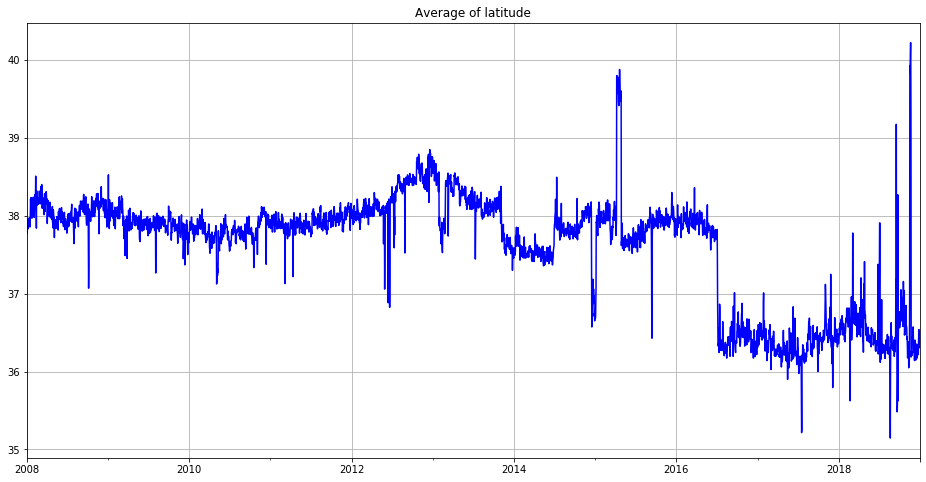

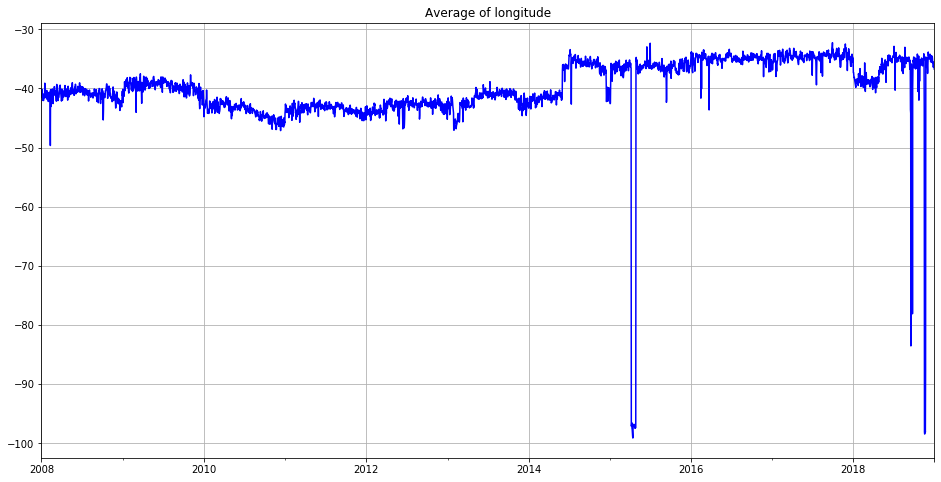

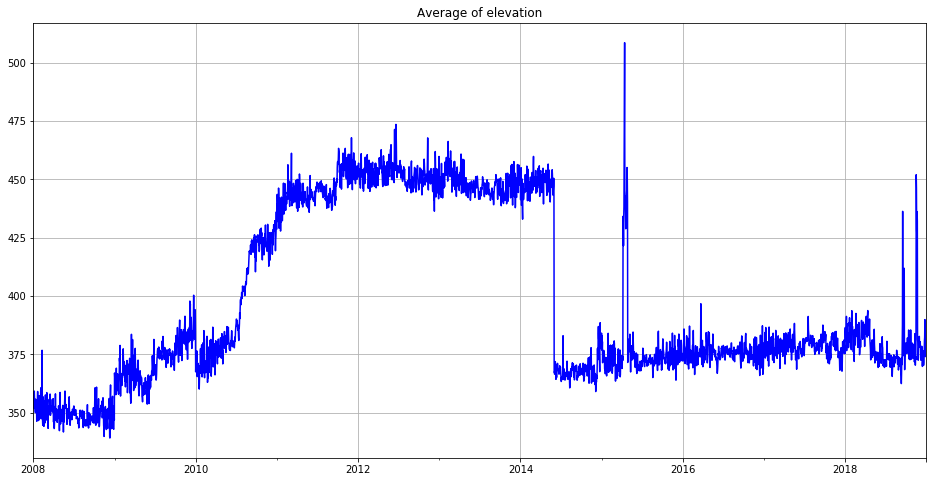

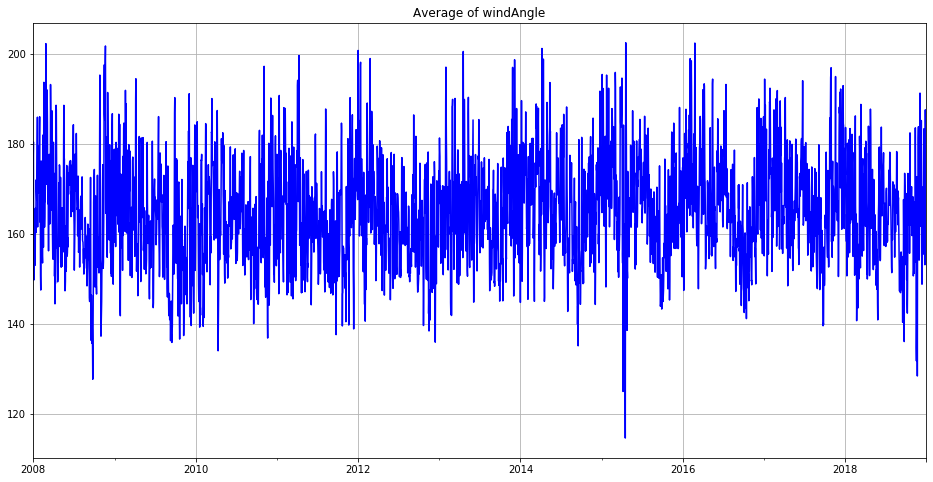

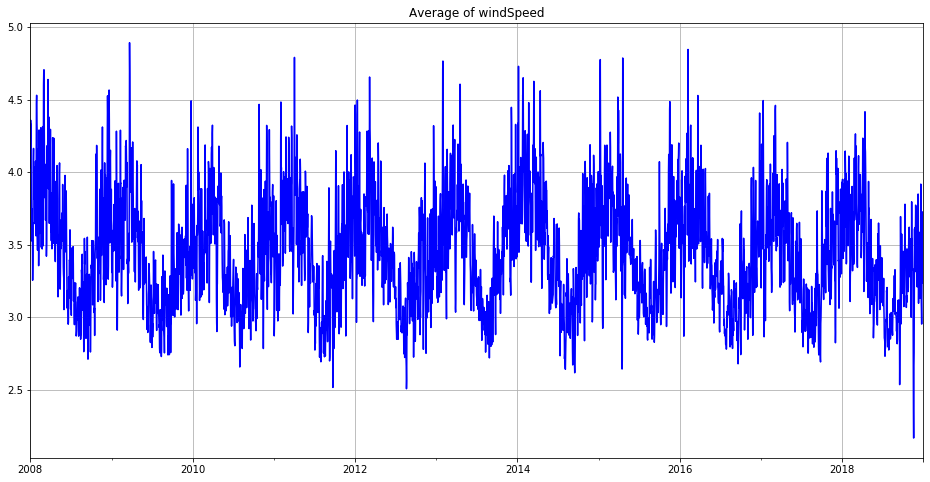

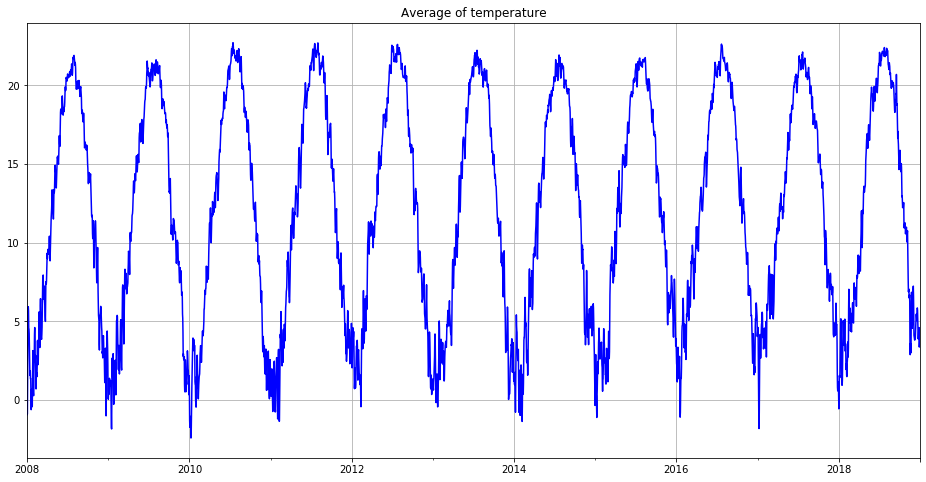

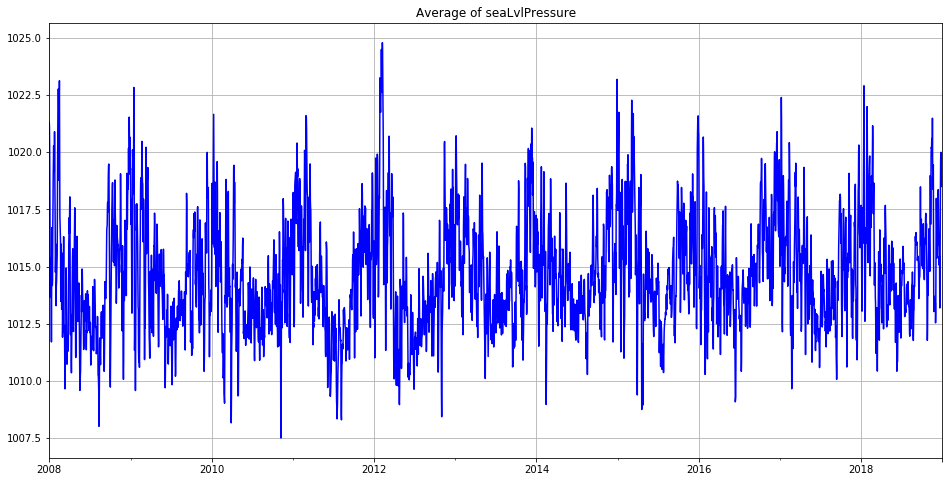

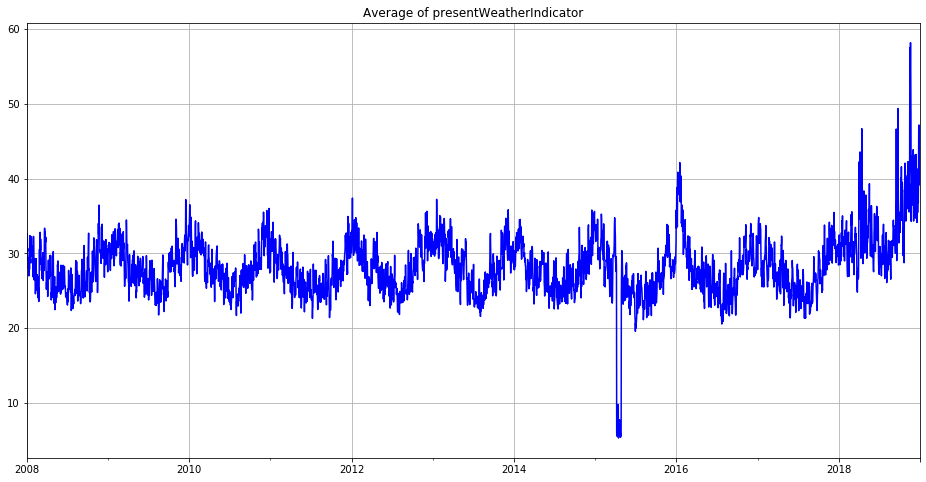

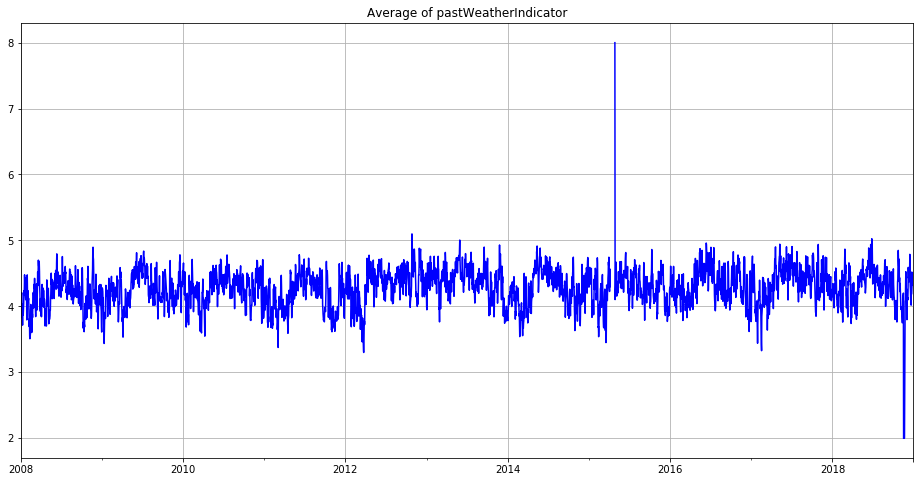

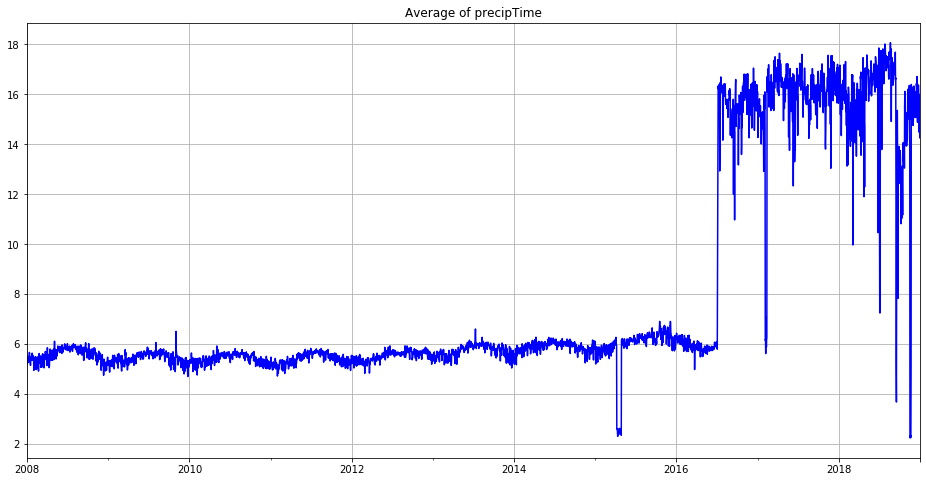

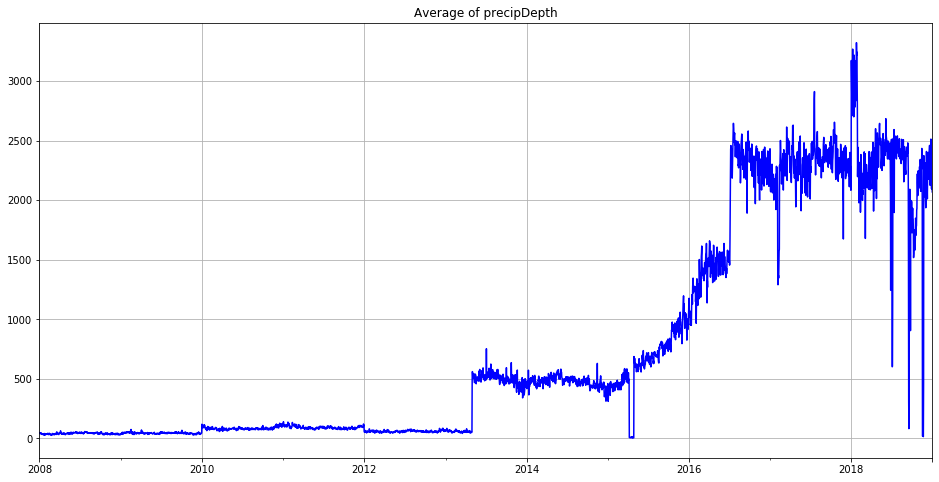

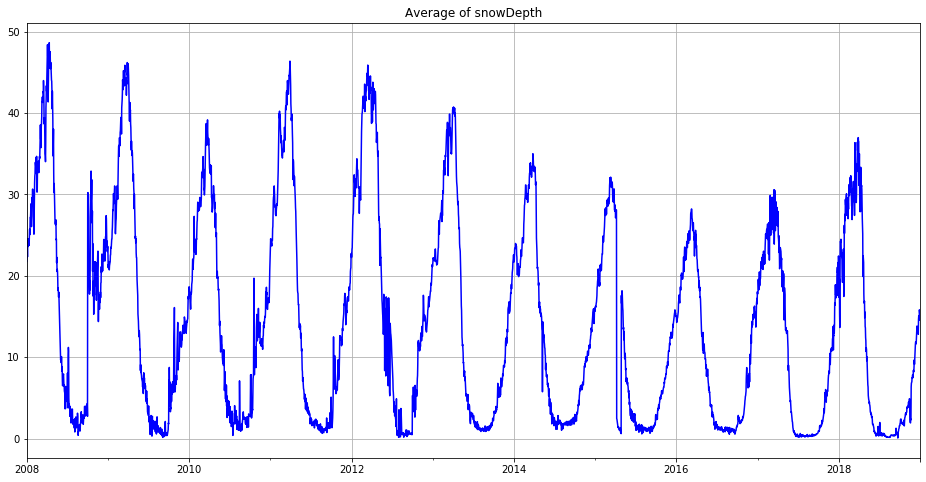

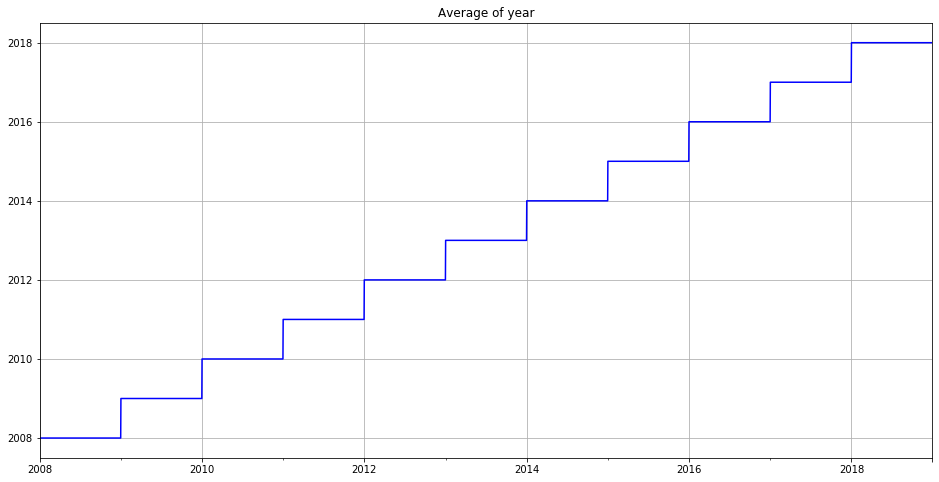

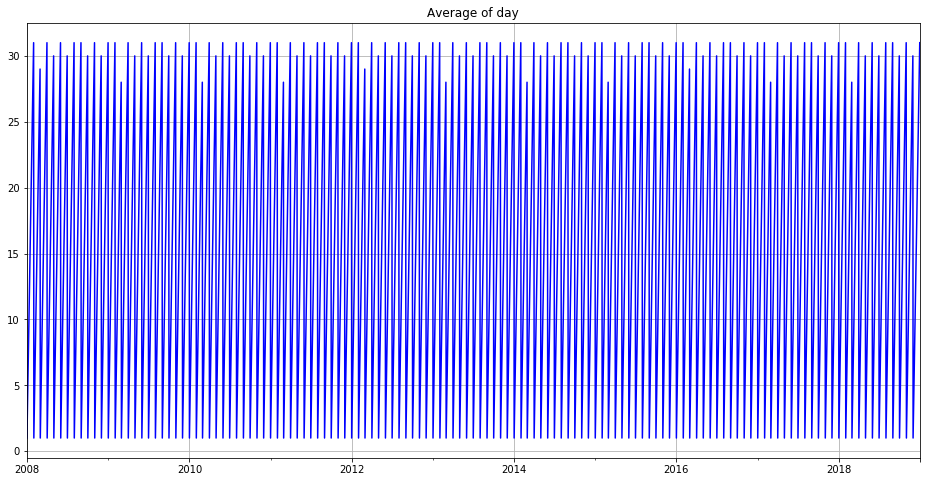

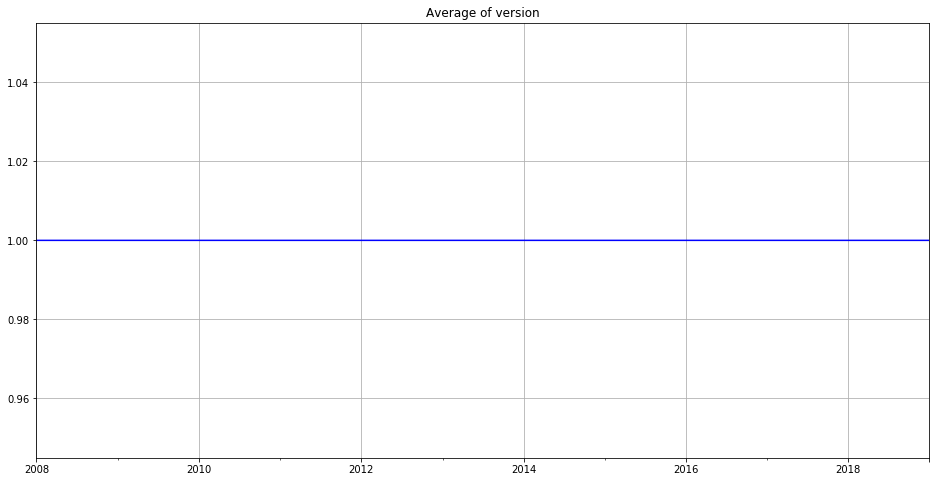

In [18]:
for col in list(means.columns):
    fig = plt.figure(figsize=(16, 8))
    #plt.style.use('dark_background')
    means[col].plot(color='b')
    plt.title('Average of {}'.format(col))
    plt.xlim([datetime(2008, 1, 1), datetime(2018, 12, 31)])
    plt.grid()
    
    # optionally, log the image to the run
    run.log_image(f'mean_{col}', plot=plt)

You can see the images logged to the run in the studio.

In [19]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
dask-dask-demo,dask-dask-demo_1580440649_506153b5,azureml.scriptrun,Running,Link to Azure Machine Learning studio,Link to Documentation


## Transform data

In [20]:
## insert any Pandas-like Dask transformation code 
df['temperature'] = df['temperature']*(9/5)+32 # 'Merica

## Write data

**Warning**: This will write ~150 GB of CSV files to your ADLSv2 storage account. This will be used to demonstrate Dask + Azure ML on an artificially larger set of files.

In [23]:
%time df.repartition(npartitions=df.npartitions*10).to_csv(f'{protocol}://{container}/noaa/isd-csv/part-*-data.csv', storage_options=STORAGE_OPTIONS)

CPU times: user 3.27 s, sys: 385 ms, total: 3.66 s
Wall time: 22min 40s


['noaa/isd-csv/part-0000-data.csv',
 'noaa/isd-csv/part-0001-data.csv',
 'noaa/isd-csv/part-0002-data.csv',
 'noaa/isd-csv/part-0003-data.csv',
 'noaa/isd-csv/part-0004-data.csv',
 'noaa/isd-csv/part-0005-data.csv',
 'noaa/isd-csv/part-0006-data.csv',
 'noaa/isd-csv/part-0007-data.csv',
 'noaa/isd-csv/part-0008-data.csv',
 'noaa/isd-csv/part-0009-data.csv',
 'noaa/isd-csv/part-0010-data.csv',
 'noaa/isd-csv/part-0011-data.csv',
 'noaa/isd-csv/part-0012-data.csv',
 'noaa/isd-csv/part-0013-data.csv',
 'noaa/isd-csv/part-0014-data.csv',
 'noaa/isd-csv/part-0015-data.csv',
 'noaa/isd-csv/part-0016-data.csv',
 'noaa/isd-csv/part-0017-data.csv',
 'noaa/isd-csv/part-0018-data.csv',
 'noaa/isd-csv/part-0019-data.csv',
 'noaa/isd-csv/part-0020-data.csv',
 'noaa/isd-csv/part-0021-data.csv',
 'noaa/isd-csv/part-0022-data.csv',
 'noaa/isd-csv/part-0023-data.csv',
 'noaa/isd-csv/part-0024-data.csv',
 'noaa/isd-csv/part-0025-data.csv',
 'noaa/isd-csv/part-0026-data.csv',
 'noaa/isd-csv/part-0027-dat

## Train XGBoost model

In [24]:
# begin data prep
df = df.fillna(0) 

In [25]:
cols = list(df.columns)
cols = [col for col in cols if df.dtypes[col] != 'object' and col not in ['version', 'datetime']]
cols

['latitude',
 'longitude',
 'elevation',
 'windAngle',
 'windSpeed',
 'temperature',
 'seaLvlPressure',
 'presentWeatherIndicator',
 'pastWeatherIndicator',
 'precipTime',
 'precipDepth',
 'snowDepth',
 'year',
 'day']

In [26]:
X = df[[col for col in cols if col not in ['temperature']]].persist()
y = df.temperature.persist()
# end data prep - persist intelligently per https://docs.dask.org/en/latest/best-practices.html

In [27]:
xgb = XGBRegressor(n_estimators=16)
%time xgb.fit(X, y)

CPU times: user 817 ms, sys: 145 ms, total: 961 ms
Wall time: 6min 12s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=16,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [28]:
%time y_pred = xgb.predict(X).compute()

CPU times: user 4.4 s, sys: 3.83 s, total: 8.23 s
Wall time: 15.6 s


In [29]:
rmse = (((y.to_dask_array().compute()-y_pred)**2).mean())**.5 # runs locally, distribute (?)
run.log('RMSE', rmse)
print(f'Training RMSE: {round(rmse, 3)}')

Training RMSE: 21.639


## Register model

In [30]:
model_path = 'xgboost_noaa_isd.joblib.dat'
joblib.dump(xgb, model_path)
xgb = joblib.load(model_path)

[04:31:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [31]:
model = Model.register(run.experiment.workspace, 
                       model_name      = 'xgboost-noaa-isd', 
                       model_path      = model_path,
                       description     = 'Dask XGBoost NOAA ISD temperature predictor',
                       model_framework = 'DaskML.XGBoostRegressor')

Registering model xgboost-noaa-isd
